# This Notebook Presents Results and Visualizations for SAE based on NCF architecture- for Last.FM dataset

In [ ]:
from typing import Callable, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from pathlib import Path
from torch.utils.data import DataLoader
export_dir = os.getcwd()
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot
import random
import math
import heapq
from scipy.special import expit  # Sigmoid function
import itertools
from IPython.display import Latex, display
import pickle
import warnings
import optuna


# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
torch.set_printoptions(sci_mode=False)

test_flag = 1

In [ ]:
pip install ipynb

In [ ]:
from ipynb.fs.defs.utils import *
from ipynb.fs.defs.data_processing import *
from ipynb.fs.defs.models import *
from ipynb.fs.defs.training import *

# Load MF Model:

for training data:

In [ ]:
model_name_mf = 'lastFM_MF_recommender'
with open(Path(export_dir,f'models/lastFM/{model_name_mf}.pkl') , 'rb') as file:
    mf_recommender = pickle.load(file)
pos_idx_ex_hidden_ = {(row): torch.tensor([item for item in pos_ex_[row] if item not in mf_recommender.pos_idx_ex_use[row]]) for row in mf_recommender.ratings.index}
neg_idx_ex_use_ = mf_recommender.neg_idx_ex_use
pos_idx_ex_use_ = mf_recommender.pos_idx_ex_use  # since dist_pop_neg_per_user_use should fit to the corresponding neg_ex_use
neg_ex_use_ = mf_recommender.neg_ex_use
neg_ex_hidden_ = mf_recommender.neg_ex_hidden

# Load NCF Model:

In [ ]:
model_name_NCF = 'lastFM_NCF_recommender'
model = torch.load(Path(export_dir,f'model/lastFM/{lastFM_NCF_recommender}.pth'), weights_only=False)

pos_idx_ex_use = model.pos_idx_ex_use
pos_idx_ex_hidden = {(row): [item for item in pos_ex_[row] if item not in pos_idx_ex_use[row]] for row in ratings_matrix.index}

model.eval()

NeuralCollaborativeFiltering(
  (user_embedding): Embedding(6039, 20)
  (item_embedding): Embedding(3706, 20)
  (fc_layers): Sequential(
    (0): Linear(in_features=40, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Latent representations from recommender- input

In [ ]:
user_embeddings = model.user_embedding.weight.detach().clone()  # Tensor of shape (num_users, embedding_dim)
item_embeddings = model.item_embedding.weight.detach().clone()   # Tensor of shape (num_items, embedding_dim)

or

In [ ]:
df_user_embeddings = pd.read_csv(Path(export_dir,'rec_csv/lastFM/ncf/users_embeddings_ncf_.csv'))
user_embeddings = torch.tensor(df_user_embeddings.values, dtype=torch.float32)

df_item_embeddings = pd.read_csv(Path(export_dir,'rec_csv/lastFM/ncf/items_embeddings_ncf_.csv'))
item_embeddings = torch.tensor(df_item_embeddings.values, dtype=torch.float32)

df_item_emb1 = df_item_embeddings.copy()
df_item_emb1.index = user_artist_matrix.columns

dataset_items = torch.tensor(df_item_embeddings.values, dtype=torch.float32)
dataset_users = torch.tensor(df_user_embeddings.values, dtype=torch.float32)

interaction_embeddings = dataset_users

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(item_embeddings)
df_cosine_sim_matrix = pd.DataFrame(cosine_sim_matrix)
df_cosine_sim_matrix

## Load SAE NCF Model

In [ ]:
test_flag=1
model_name_SAE_NCF = 'lastFM_SAE_NCF'

sae_model = torch.load(Path(export_dir,f'models/lastFM/{model_name_SAE_NCF}.pth'), weights_only = False)
sae_model.eval()

test_subset_users = sae_model.test_subset_users_ind
test_subset_items = sae_model.test_subset_items_ind
train_subset_users = [i for i in user_artist_matrix.index if i not in test_subset_users]


optimizing SAE params using optuna

In [ ]:
def objective(trial):
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Suggest hyperparameters
    mse_weight = trial.suggest_loguniform('mse_weight', 1e-1, 1e1)  # 0.1 -> 10
    sparsity_weight = trial.suggest_loguniform('l1_weight', 1e-5, 1e0)  # 1e‑5 -> 1
    kl_weight = trial.suggest_loguniform('kl_weight', 1e-5, 1)   # 1e‑5 -> 1
    output_loss_weight = trial.suggest_uniform('output_loss', 0.0, 20.0)  # 0 -> 20


    # Training SAE
    sae_model = SparseAutoencoderNCF(input_dim=100, hidden_dim=70, tie_weights=True)
    train_sparse_autoencoder(model,sae_model,
         user_embeddings, item_embeddings, epochs=30, lr=0.001, device='cpu',
        mse_weight = mse_weight,
        sparsity_weight  = sparsity_weight,
        kl_weight  = kl_weight,
        output_loss_weight     = output_loss_weight
    )
    # Extract the item latents and compute MS Score
    _, latents_items = sae_model(item_embeddings)
    avg_ms = ms_score_new(df_cosine_sim_matrix, latents_items)

    return float(avg_ms)

# Create and run the study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=20)

df_trials = study.trials_dataframe()

df_sorted = df_trials.sort_values("value", ascending=False)
df_sorted.to_csv(export_dir+'rec_csv/lastFM/sae_ncf_params_optuna.csv', index=False)


df_trials

# SAE Evaluation:

In [ ]:
reconstructions_users, latents_users=sae_model(user_embeddings)
reconstructions_items, latents_items=sae_model(item_embeddings)

latents_users=latents_users.detach().clone()
latents_items=latents_items.detach().clone()

reconstructions_users=reconstructions_users.detach().clone()
reconstructions_items=reconstructions_items.detach().clone()

In [ ]:
avg_ms_score= ms_score_new(df_cosine_sim_matrix, latents_items)

#---------
#items:
latents_item_df = pd.DataFrame(latents_items.numpy())
latents_item_df.index = user_artist_matrix.columns

reconstruction_item_df = pd.DataFrame(reconstructions_items.numpy())
reconstruction_item_df.index = user_artist_matrix.columns


users_ind= sae_model.test_subset_users_ind

lists_compare_table = pd.DataFrame(0, index=users_ind, columns=['RBO Score', 'Kendall Tau Score'])


for user in lists_compare_table.index:

    top_rec_user_id_orig  = get_top_k_recommendations(model,user_id,range(2277), 30)[0]
    top_rec_user_id_rec  = get_top_k_recommendations_new(model, user,reconstructions_users, reconstructions_items, range(2277), 30)[0]

    lists_compare_table.loc[user,'RBO Score'] = rbo(top_rec_user_id_orig, top_rec_user_id_rec)

    lists_compare_table.loc[user,'Kendall Tau Score'] = kendall_tau(top_rec_user_id_orig], top_rec_user_id_rec)

print(f'{round(float(lists_compare_table.mean().iloc[0]),6)} | {round(float(lists_compare_table.mean().iloc[1]),6)}')
print(f'averaged MS score: {avg_ms_score}')

In [ ]:
latents_numpy_array_all_usr = latents_users.detach().clone()
latents_df_all_usr = pd.DataFrame(latents_numpy_array_all_usr)
latents_df_all_usr.index = user_artist_matrix.index


latents_items_numpy_array = latents_items.detach().clone().numpy()
latents_items_df = pd.DataFrame(latents_items_numpy_array)
latents_items_df.index = user_artist_matrix.columns

# sparsity test:

In [ ]:
# how many neurons are activated or inavtivated   for each neuron
print(np.array((latents_users.detach() == 0).sum(axis=1)).mean()) # sums up over columns for each column- item
print(np.array((latents_users.detach() != 0).sum(axis=1)).mean())

print(np.array((latents_items.detach() == 0).sum(axis=1)).mean()) # sums up over columns for each column- item
print(np.array((latents_items.detach() != 0).sum(axis=1)).mean())

13.80394104984269
8.19605895015731
13.910685375067459
8.089314624932541


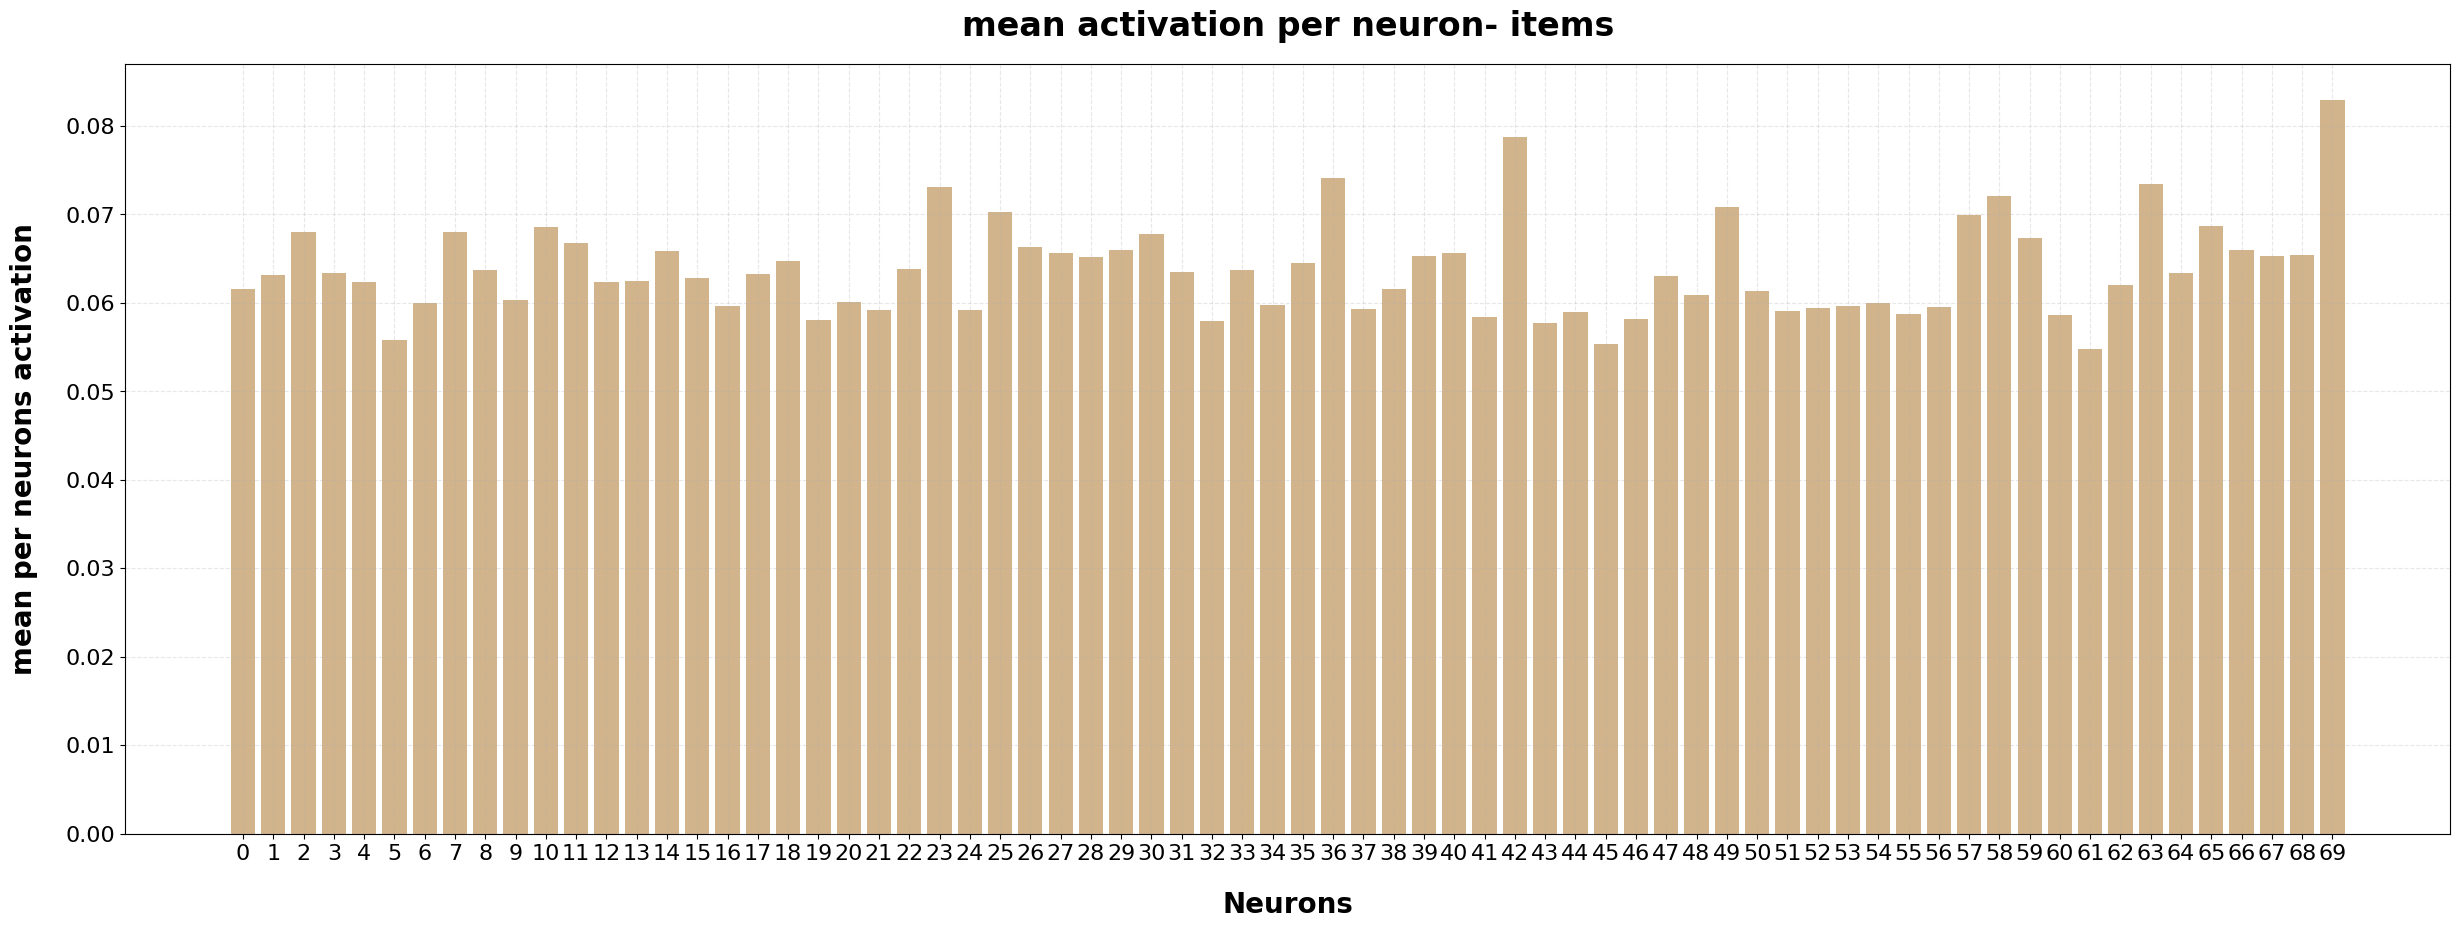

In [ ]:
# averaged activation on every neuron:

plt.figure(figsize=(11, 6))
r= plt.bar(latents_items_df.columns, latents_items_df.mean(), color='mediumblue', width = 0.5)
plt.title(f'mean activation per neuron- items', pad=20,weight='bold',fontsize=24)
plt.xlabel('Neurons', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('mean per neurons activation', labelpad=20,weight='bold',fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xticks(latents_items_df.columns,fontsize=16)
plt.yticks(fontsize=16)

plt.show()



# Testing K most dominant movies per neuron
i.e.- topK movies that yielded the highest activation per neuron.

In [ ]:
K = 50
highly_activate_movies2neurons= pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,K))
for neuron in latents_items_df.columns:
  highly_activate_movies2neurons.loc[neuron,:] = latents_items_df.loc[:,neuron].nlargest(ITEMS_lastFM)[0:K].index

highly_activate_movies2neurons

# Latent activation Visualizations

In [ ]:
size = K

dominant_genre = {}
for neuron in latents_items_df.columns:

  activated_per_neuron = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuron,:],:]
  norm_activated_per_neuron = activated_per_neuron.sum()/size

  plt.figure(figsize=(30, 8))
  plt.title(f'Neuron {neuron} - Genre Wise Distribution of the top{size} Dominant Artists', pad=20,weight='bold',fontsize=24)
  plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)

  plt.bar(genres, norm_activated_per_neuron[genres], color='tan',edgecolor = 'darkgoldenrod', hatch = '//')
  plt.ylabel('Items Percentage', labelpad=20,weight='bold',fontsize=20)
  plt.xticks(rotation=90, fontsize=18)
  plt.yticks(fontsize=18)
  plt.grid(True, linestyle='--', alpha=0.5)



In [ ]:
activated_per_neuron = df_artists_tags.loc[highly_activate_movies2neurons.iloc[1,:],:]
activated_per_neuron.sum()

## Quantitative results

PURITY


In [ ]:
K = 20
highly_activate_movies2neurons= pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,K))
for neuron in latents_items_df.columns:
  highly_activate_movies2neurons.loc[neuron,:] = latents_items_df.loc[:,neuron].nlargest(ITEMS)[0:K].index

In [ ]:
neuron = 57

tar_genre =['folk'] #['folk']#['rock','indie_rock']#['hardcore', 'metalcore','screamo','post_hardcore']#['electronic']#['pop','dance','female_vocalists','hip_hop']#['electronic','dance', 'trance']#['country']#['reggae', 'folk', 'ska']
a=df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuron,:],tar_genre]
purity = a.sum(axis=1)
(purity>0).sum()/K

monosemanticity score:

In [ ]:
ms_score_all_neurons(df_cosine_sim_matrix, latents_items)

Analyze monosemantic neurons

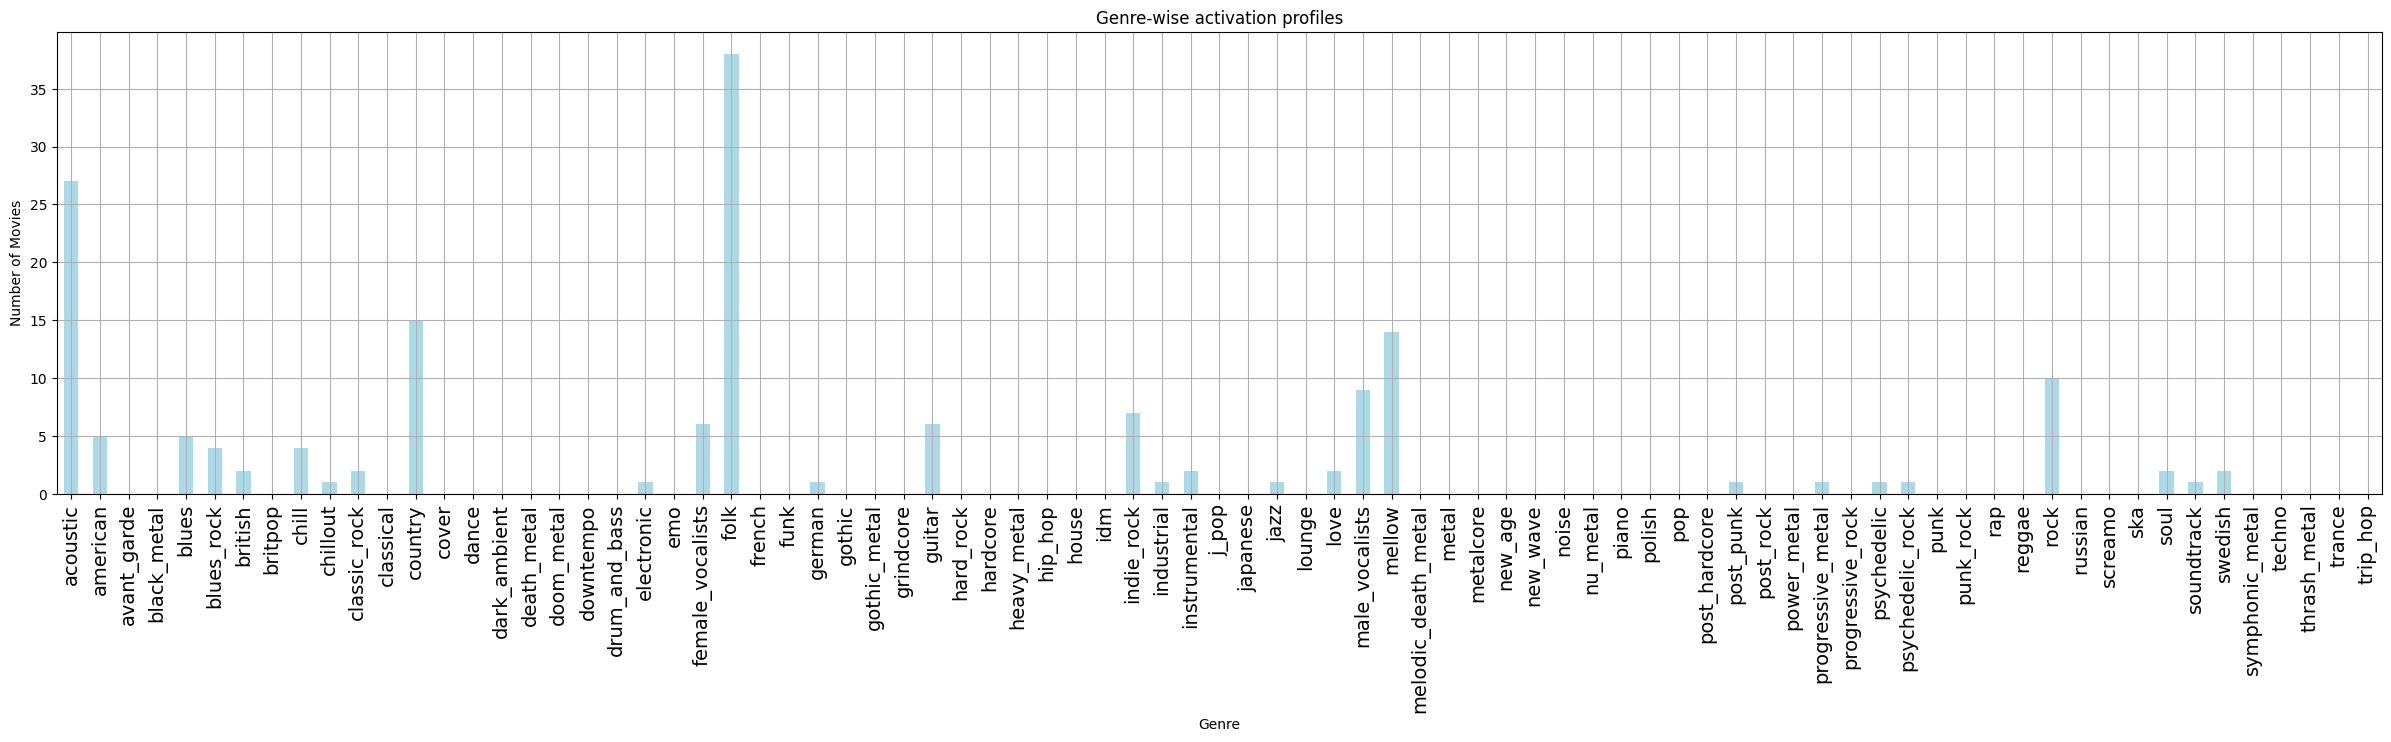

,Artist,tags
artist,,
Blitzen Trapper,Beanfield,"[folk, acoustic, chill, male_vocalists]"
John Prine,Xploding Plastix,"[country, folk]"
Monsters of Folk,UNKLE,"[folk, male_vocalists, acoustic, american]"
Rocky Votolato,Quantic,"[acoustic, folk, country]"
Deer Tick,Goldie,"[country, folk, american, rock]"
Sea Wolf,Télépopmusik,"[folk, mellow, acoustic, love]"
Two Gallants,Zero 7,"[folk, acoustic, indie_rock, post_punk]"
Okkervil River,Kylesa,"[indie_rock, folk, rock, acoustic]"
Josh Ritter,The Cinematic Orchestra,"[folk, soundtrack, acoustic, mellow]"


In [ ]:
neuro = 57
artist_clusters_df1 = top_tags_per_artist[['artist', 'tags']]
artist_clusters_df1 = artist_clusters_df1.loc[highly_activate_movies2neurons.iloc[neuro,:],:]
merged_df_ = artist_clusters_df1.join(most_popular['rank']*100/ITEMS_lastFM, how='left')

num_per_genre_recommended = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuro,:],:].sum()

plt.figure(figsize=(30,10))
(num_per_genre_recommended/K).plot(kind='bar', color='tan')
plt.title('Genre-wise activation profiles')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

merged_df_.iloc[0:10]

In [ ]:
neuro = 33
artist_clusters_df1 = top_tags_per_artist[['artist', 'tags']]
artist_clusters_df1 = artist_clusters_df1.loc[highly_activate_movies2neurons.iloc[neuro,:],:]
merged_df_ = artist_clusters_df1.join(most_popular['rank']*100/ITEMS_lastFM, how='left')

num_per_genre_recommended = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuro,:],:].sum()

plt.figure(figsize=(30,10))
(num_per_genre_recommended/K).plot(kind='bar', color='tan')
plt.title('Genre-wise activation profiles')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

merged_df_.iloc[0:10]

In [ ]:
neuro = 58
artist_clusters_df1 = top_tags_per_artist[['artist', 'tags']]
artist_clusters_df1 = artist_clusters_df1.loc[highly_activate_movies2neurons.iloc[neuro,:],:]
merged_df_ = artist_clusters_df1.join(most_popular['rank']*100/ITEMS_lastFM, how='left')

num_per_genre_recommended = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuro,:],:].sum()

plt.figure(figsize=(30,10))
(num_per_genre_recommended/K).plot(kind='bar', color='tan')
plt.title('Genre-wise activation profiles')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

merged_df_.iloc[0:10]

## Other concepts:

popularity pattern

In [ ]:
pop_rank_df = pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,50))
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(ITEMS_lastFM)[0:50]
  for id, movie in enumerate(a1.index):
    pop_rank_df.loc[neuron,id]= np.where(num_users_per_artist_sort.index == a1.index[id])[0][0]
pop_rank_df.mean(axis=1)/ITEMS_lastFM

In [ ]:
with pd.option_context('display.max_rows', None):
    print(pop_rank_df.mean(axis=1)*100/ITEMS_lastFM)

0     27.659201
1     42.446201
2     33.500220
3      3.833992
4     49.411506
5      1.150637
6     12.327624
7     53.768116
8      6.069390
9     33.790075
10    21.888450
11    38.045674
12     4.743083
13     3.952569
14    30.830040
15    19.148002
16    19.218270
17    34.901186
18    21.291173
19    39.692578
20    18.410189
21    15.915679
22    26.464646
23    22.323232
24     3.741765
25    36.253843
26    52.981994
27    16.275801
28    25.274484
29     1.207729
30    26.310935
31    33.184014
32     1.730347
33    30.592885
34    12.397892
35     0.461133
36    46.794027
37    24.014054
38    15.098814
39     4.852877
40    46.855512
41    33.833992
42    57.808520
43     1.032060
44    37.900747
45    12.520861
46    17.400088
47    68.041282
48    32.687747
49    15.963988
50    34.440053
51     7.922705
52    22.244181
53    24.440053
54    14.703557
55    77.140975
56    11.264822
57    26.341678
58    25.700483
59    30.768555
60    11.374616
61     3.675889
62    38

# Latent user representation intervention

Activate one neuron in Latent representation

In [ ]:
x = item_embeddings.detach()[1016]
x = x.view(1, 100)

latent_pre_act = sae_model.encoder_linear(x) # (batch, hidden_dim)
curr_latents = sae_model.topk_activation(latent_pre_act)
curr_latents = torch.zeros_like(curr_latents)

neuron_one = 11
level = 4
curr_latents[:,neuron_one]=level
recons_unique = sae_model.decoder(curr_latents)



#-----------------------------------------------------------------------------------------------------------------------------------

_, editeEncOut_recons_latents= sae_model(recons_unique.detach())
df_editeEncOut_recons_latents_post_enc = pd.DataFrame(editeEncOut_recons_latents.detach().numpy())

df_recons_edited = pd.DataFrame(recons_unique.detach().numpy())



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.bar(latents_items_df.columns, df_editeEncOut_recons_latents_post_enc.T[0], color='coral')
ax1.bar(latents_items_df.columns+0.1, latents_items_df.mean(), color='blue',width=0.1)

ax1.set_title(f'Activation of recons of edited latents into enc, per Neuron',fontsize=14, weight='bold')
ax1.set_xlabel('Neurons',fontsize=17, weight='bold')
ax1.set_ylabel('Mean Neuron Activation',fontsize=17, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(range(len(latents_items_df.columns)))
ax1.set_xticklabels(latents_items_df.columns, rotation=90,fontsize=15)
ax1.tick_params(axis='y', labelsize=15)


normalized_activation = df_editeEncOut_recons_latents_post_enc.T[0] / latents_items_df.mean()

ax2.bar(latents_items_df.columns, normalized_activation, color='coral')
ax2.set_title(f'Activation of recons of edited latents into enc, per Neuron',fontsize=14, weight='bold')
ax2.set_xlabel('Neurons',fontsize=14, weight='bold')
ax2.set_ylabel('Normalized Activation- by mean',fontsize=14, weight='bold')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_xticks(range(len(latents_items_df.columns)))
ax2.set_xticklabels(latents_items_df.columns, rotation=90,fontsize=15)
ax2.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()


#----------------------------------------------------------------------------------------------------------------------------------

movie_num = 50
movie_num_test = 50

cosine_res = {}

test_mod_recons_embeddings = recons_unique
df_test_mod_recons_embeddings = pd.DataFrame(test_mod_recons_embeddings.detach().numpy())
magnitude_test_mod_recons_embeddings = np.linalg.norm(df_test_mod_recons_embeddings) ## TODO- maybe [0]

for i, movie_id in enumerate(user_artist_matrix.columns):
  # if i in train_subset:
    curr_dot_product = np.dot(
    df_item_emb1.loc[movie_id].to_numpy(),
    df_test_mod_recons_embeddings.iloc[0].to_numpy()
)
    curr_magnitude = np.linalg.norm(df_item_emb1.loc[movie_id])
    curr_cosine_similarity = curr_dot_product / (magnitude_test_mod_recons_embeddings * curr_magnitude)

    cosine_res[movie_id] = curr_cosine_similarity

max_key = max(cosine_res, key=cosine_res.get)
genres_test_mod_recons_embeddings = df_artists_tags.columns[(np.where(df_artists_tags.loc[max_key]==1)[0])].tolist()
topK_test_mod_recons_embeddings = heapq.nlargest(movie_num, cosine_res.items(), key=lambda x: x[1])


#-----------------------------------------------------------------------------------------------------------------------------------

table1 = pd.DataFrame(0, index=range(movie_num), columns=['movie', 'name','rank'])
for i in table1.index:
  table1.iloc[i,0] =  topK_test_mod_recons_embeddings[i][0]
  table1.iloc[i,1] =  str(df_artists_tags.columns[(np.where(df_artists_tags.loc[topK_test_mod_recons_embeddings[i][0]]==1)[0])].tolist())
  table1.iloc[i,2] =  most_popular.loc[topK_test_mod_recons_embeddings[i][0],'rank']/2277


#-----------------------------------------------------------------------------------------------------------------------------------

a=[topK_test_mod_recons_embeddings[i][0] for i in range(len(topK_test_mod_recons_embeddings))]
b = (df_artists_tags.loc[a])


plt.figure(figsize=(20, 5))
numerator = (df_artists_tags.loc[a].sum(axis=0)) if 'Cluster' in df_artists_tags.columns else (df_artists_tags.loc[a].sum(axis=0))

plt.bar(genres, numerator/movie_num, color='coral')
plt.title(f'Genres of {movie_num} most similar movies',fontsize=16, weight='bold')
plt.xlabel('genres',fontsize=15, weight='bold')
plt.ylabel('number of movies per genre',fontsize=17, weight='bold')
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)

#--------------------------------------------------------------------------------------------------------------------------------------

activated_per_neuron = df_artists_tags.loc[highly_activate_movies2neurons.iloc[neuron_one,:],:]
norm_activated_per_neuron = activated_per_neuron.sum()/50
plt.figure(figsize=(16, 8))
plt.bar(activated_per_neuron.columns, norm_activated_per_neuron, color='tan', width=0.6)
plt.title(f'Neuron {neuron_one} - Genre Distribution of the 50 Most Dominant Movies', pad=20,weight='bold',fontsize=24)
plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Movies Percentage', labelpad=20,weight='bold',fontsize=20)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)


table1

In [ ]:
N=20

# USE CASES

choose an audience

In [ ]:
'''find the group'''
'''list of users that listened to artists of certain genre, sorted by the number of
artists of the certain genre wrt the total number of artists ranked by the user'''


N=40
group_genre = 'electronic'
group_genre_movies_id = np.where(df_artists_tags[group_genre] == 1)

group_genre_movies_name = df_artists_tags.iloc[group_genre_movies_id].index
# df_movies contains all movies, whereas ratingns_matrix contain only those users have watched
rel_group_genre_movies_name = [movie for movie in group_genre_movies_name if movie in user_artist_matrix.columns]
part_sum_for_group_genre=user_artist_matrix.loc[:,list(rel_group_genre_movies_name)].sum(axis=1)/user_artist_matrix.sum(axis=1)
argmax_user = part_sum_for_group_genre.iloc[sae_model.test_subset_users_ind].nlargest(N).index # N users watched the biggest amount of 'genre' movies vs the total num of movies


usersGroup=pd.DataFrame(part_sum_for_group_genre.loc[argmax_user])
usersGroup.columns = [f"percentage of {group_genre} movies"]

usersGroup

## test some of the users in the group

In [ ]:
user_id = 4042#6923#2978#21292#2978#5000#14847#9512#test_user

user_artist_matrix_counts = df_joined_user_music_new.groupby(['user_id', 'artist']).size().unstack(fill_value=0)
artists_played_per_user= user_artist_matrix_counts.iloc[user_id, :][user_artist_matrix_counts.iloc[user_id, :] >= 1]


artist_clusters_df = tagging_w_cluster[['artist', 'cluster_id', 'cluster_top_tags']]
artist_clusters_df = artist_clusters_df.set_index('artist')
artists_played_per_user_df = artists_played_per_user.to_frame(name='play_count')
merged_df_ = artists_played_per_user_df.join(artist_clusters_df, how='left')
merged_df_ = merged_df_.join(df_tags, how='left')
merged_df_ = merged_df_.join(most_popular['rank'], how='left')

merged_df_sorted = merged_df_.sort_values(by='play_count', ascending=False)

num_per_genre_listened = df_artists_tags.loc[merged_df_sorted.index,:].sum()

plt.figure(figsize=(30,6))
num_per_genre_listened.plot(kind='bar', color='lightblue')
plt.title(f'artists ranked by user {user_id}', pad=20,weight='bold',fontsize=24)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

merged_df_sorted



recommended sartists for users:

In [ ]:
sorted_user_recommedations_pq_ind = get_top_k_recommendations_new_all(model, user_id,user_embeddings, item_embeddings, range(2277), 30)[1]
sorted_user_recommedations_pq_name = list(user_artist_matrix.columns[sorted_user_recommedations_pq_ind])

pq_recommendations_analysis_per_user = pd.DataFrame(sorted_user_recommedations_pq_name,columns = ['artist_name'])
pq_recommendations_analysis_per_user.index = sorted_user_recommedations_pq_name
pq_recommendations_analysis_per_user = pq_recommendations_analysis_per_user.join(merged_df__all, how='left')
pq_recommendations_analysis_per_user = pq_recommendations_analysis_per_user.join(most_popular['rank'], how='left')
pq_recommendations_analysis_per_user['rank']=pq_recommendations_analysis_per_user['rank']*100/2277
pq_recommendations_analysis_per_user['real_artist_index'] = sorted_user_recommedations_pq_ind
pq_recommendations_analysis_per_user.index =  range(0,pq_recommendations_analysis_per_user.shape[0])


pq_recommendations_analysis_per_user[0:10]

In [ ]:
num_per_genre_pq_recommended = df_artists_tags.loc[pq_recommendations_analysis_per_user.loc[0:10,'artist_name'],:].sum()

plt.figure(figsize=(30,6))
num_per_genre_pq_recommended.plot(kind='bar', color='lightblue')
plt.title('Genre-wise users profiles')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90,fontsize=14)
plt.grid(True)
plt.show()

# USE CASE 1- Modify Item Latent Representation

## Item Exposure to new audience

In [ ]:
numUsersTotopk = []
numUsersOuttopk_orig = []
movie_num = 2277
test_artist = 'The Whitest Boy Alive'
ind_movie = np.where(df_item_emb1.index==test_artist)[0][0]
th = 200
neuron = 57


neuron_levels = [0,1,2,3, 4]

'''what place 'test_artist' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(usersGroup.index)), columns=['user', 'orig rec rank']+[f'new rec rank_lev{lev}' for lev in neuron_levels[1:]])

for ind_lev, level in enumerate(neuron_levels):
  print(f'level: {level}')

  for ind,user_movie_test in enumerate(usersGroup.index):


    # modified movie:
    movie_act =  latents_items_df.copy().loc[test_artist,:]
    min_val2 = movie_act.min()
    max_val2 = movie_act.max()
    movie_act = (movie_act - min_val2) / (max_val2 - min_val2 + 1e-8)

    movie_act_new = movie_act.copy(deep=True)
    movie_act_new.iloc[neuron] = level

    movie_act_new= movie_act_new * (max_val2 - min_val2) + min_val2

    recons_unique = sae_model.decoder(torch.tensor(movie_act_new))

    df_item_emb_copy= df_item_emb.copy(deep=True)
    df_item_emb_copy.iloc[ind_movie,:]=pd.DataFrame(recons_unique.detach().numpy()).iloc[:,0]


    if level == 0 :
      top_rec_user_id_orig = recommend_pq_all(user_movie_test,dataset_users,df_item_emb_copy, movie_num)
      table1_rec_Wname_orig = table_maker_new(movie_num, top_rec_user_id_orig, df_tags, pop_ranking=num_users_per_artist_sort)

    # user_movie_test =4617#588#3800#1283#4617 #2998
    top_rec_user_id_new = recommend_pq_all(user_movie_test, dataset_users,df_item_emb_copy, movie_num)
    table1_rec_Wname_new = table_maker_new(movie_num, top_rec_user_id_new, df_tags, pop_ranking=num_users_per_artist_sort)


    # #--------------------------------------------------------------------------------------

    table.iloc[ind,0] = user_movie_test
    if level == 0 :
      table.iloc[ind,1] = np.where(table1_rec_Wname_orig.iloc[:,0]==test_artist)[0][0]
    else:
      table.iloc[ind,1+ind_lev] = np.where(table1_rec_Wname_new.iloc[:,0]==test_artist)[0][0]

  to_top50 = []
  remain_top50 = []
  from_top50 = []
  count_in_top50_orig = 0
  count_out_top50_orig = 0
  for i in table.index:
    if table.iloc[i,1]>th:
      count_out_top50_orig+=1
      if table.iloc[i,1+ind_lev] <= th+10:
        to_top50.append(table['user'][i])

    else: continue

  numUsersOuttopk_orig.append(count_out_top50_orig)
  numUsersTotopk.append(len(to_top50))




fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

ax1.bar(neuron_levels, numUsersTotopk, color='tan',width = 0.3)
ax1.axhline(y=numUsersOuttopk_orig[0], color='blue', linestyle='--')
ax1.set_xlabel('Neuron 5- Activation Level',fontsize=16)
ax1.set_ylabel('Num of Users',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(['Number of users whose original\ntopK recommendations list\ndoes not contain the relevant artist'
            ],loc ='center left')
ax1.tick_params(axis='y', labelsize=16)

table

# Latent user representation intervention

 ##  USE CASE 2: Nudging users toward new content

choose an audience

In [ ]:
N=40
group_genre = 'folk'
group_genre_movies_id = np.where(df_artists_tags[group_genre] == 1)

group_genre_movies_name = df_artists_tags.iloc[group_genre_movies_id].index
# df_movies contains all movies, whereas ratingns_matrix contain only those users have watched
rel_group_genre_movies_name = [movie for movie in group_genre_movies_name if movie in user_artist_matrix.columns]
part_sum_for_group_genre=user_artist_matrix.loc[:,list(rel_group_genre_movies_name)].sum(axis=1)/user_artist_matrix.sum(axis=1)
argmax_user = part_sum_for_group_genre.iloc[sae_model.test_subset_users_ind].nlargest(N).index # N users watched the biggest amount of 'genre' movies vs the total num of movies

# users watched moost of group_genre movies, the number of group_genre movies
# they watched, and the number of movies they watched from all genres
usersGroup=pd.DataFrame(part_sum_for_group_genre.loc[argmax_user])
usersGroup.columns = [f"percentage of {group_genre} artists"]

usersGroup

,percentage of folk movies
18145,0.913043
11382,0.818182
4939,0.785714
10872,0.783784
8639,0.777778
16885,0.750000
20855,0.714286
20310,0.710526
13636,0.700000
20966,0.694444


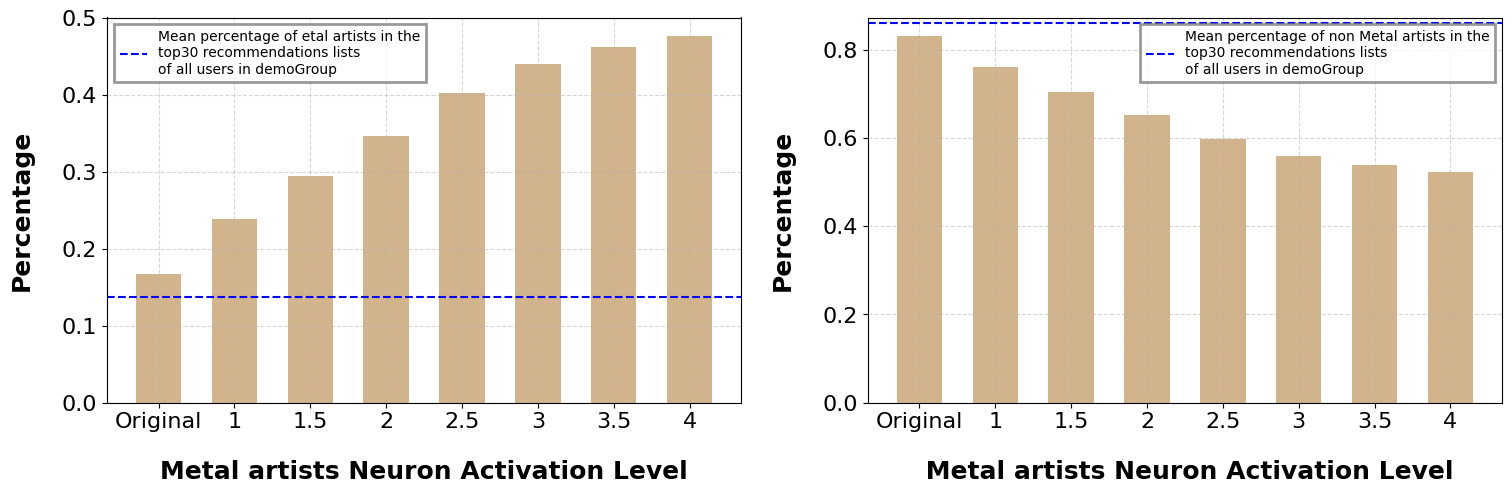

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0
genre_expose = 'rock' #'rock'


'''dealing here with orig/new results and old/new genres'''


neuron_levels = [0.5, 1, 1.5, 2,2.5,3,3.5,4]



'''what place 'test_movie' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(usersGroup.index)), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:

  no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in usersGroup.index:

    top_rec_user_orig = get_top_k_recommendations_new_all(model, user2,dataset_users, dataset_items, range(2277), movie_num2)[1]
    top_rec_user_id_orig = top_rec_user_orig.tolist()
    a_orig = df_artists_tags.iloc[top_rec_user_id_orig,:].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[genre_expose])/movie_num2

    orig_genres_percentage_newGenre = a_orig.loc[genre_expose]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)



    # new/ current results: for old and new/test/curr genres:

    # modified users:
    x2 = dataset_users[user2].view(1, 100)
    latent_pre_act = sae_model.encoder_linear(x2)
    curr_latents2 = sae_model.topk_activation(latent_pre_act)
    curr_latents2 = latents_all_usr[user2].clone()

    min_val2 = curr_latents2.min()
    max_val2 = curr_latents2.max()
    curr_latents2 = (curr_latents2 - min_val2) / (max_val2 - min_val2 + 1e-8)

    if level != 0.5:

      curr_latents2[69]=level

    curr_latents2= curr_latents2 * (max_val2 - min_val2) + min_val2
    recons_user2 = sae_model.decoder(curr_latents2)

    df_user_emb_copy2= dataset_users.clone()
    df_user_emb_copy2[user2,:] = recons_user2.detach()

    top_rec_user2 = get_top_k_recommendations_new_all(model, user2,df_user_emb_copy2, dataset_items, range(2277), movie_num2)[1]#rec_gen_new(movie_num, user, df_b_u_emb, df_b_i_emb, df_user_emb.iloc[user_movie_test,:], df_item_emb_copy)


    top_rec_user_id_new2 = top_rec_user2.tolist()
    a2 = df_artists_tags.iloc[top_rec_user_id_new2,:].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[genre_expose])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[genre_expose]/movie_num2


    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)

    #--------------------------------------------------------------------------------------



  # each item in the list represents the averaged percentage of artista of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


# IF WE'RE TALKING ABOUT BLOCKIING- ADD THIS REPLACE WITH neuron_levels_names
neuron_levels_block = neuron_levels.copy()
# neuron_levels_block = [item* (-1) for item in neuron_levels_block]
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
ax1.set_xlabel('Metal artists Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax1.legend([f'Mean percentage of {genre_expose} artists in the\ntopK recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
ax2.bar(neuron_levels, meanOldGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
ax2.set_xlabel(' Metal artists Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non Metal artists in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)




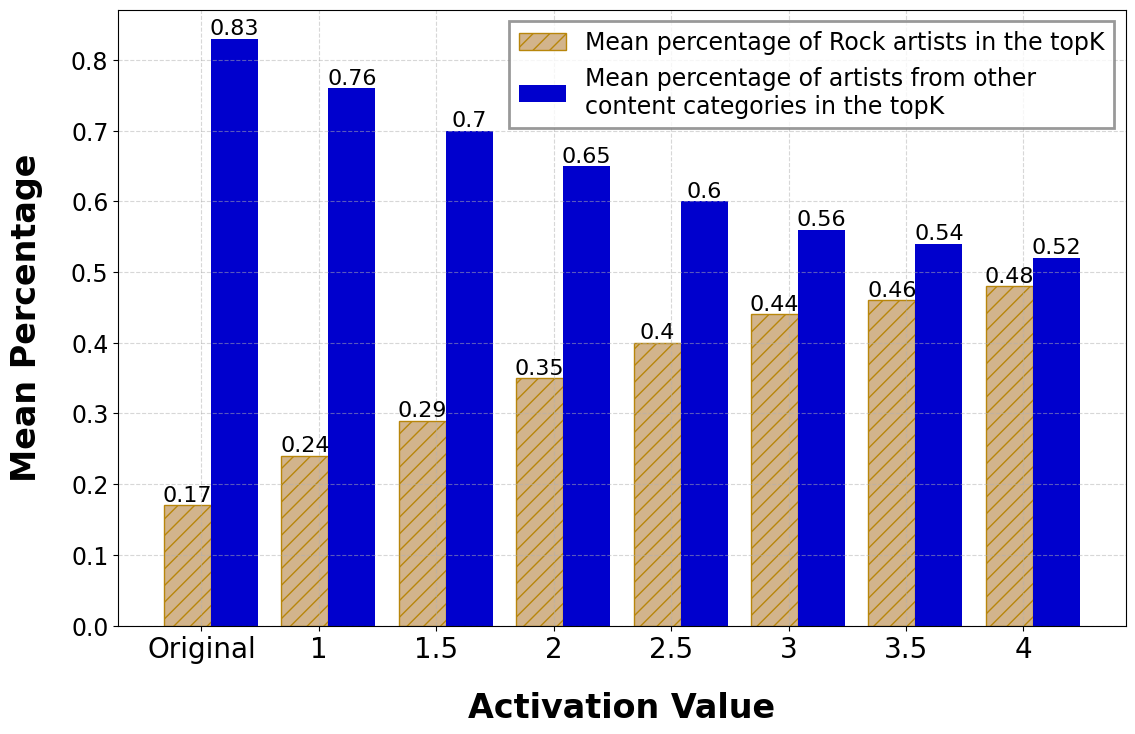

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(13, 8))


# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.2, hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=16)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([0.7, 1.2, 1.7, 2.2, 2.7, 3.2,3.7,4.2], b, color='mediumblue', width= 0.2)

ax1.bar_label(r2,fontsize=16)

ax1.set_xlabel('Activation Value', labelpad=20,weight='bold',fontsize=24)

ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=24)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks([0.56, 1.06, 1.56, 2.06, 2.56, 3.06,3.56,4.06])


ax1.tick_params(axis='both', labelsize=17)
ax1.set_xticklabels(neuron_levels_block,fontsize=20)
leg = plt.legend([f'Mean percentage of Rock artists in the topK', f'Mean percentage of artists from other\ncontent categories in the topK'],frameon=True, loc='upper right', fontsize=17, fancybox=False)

frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






-

 ## USE CASE  3: Post hoc content suppression

pick users

In [ ]:
usersGroup = generate_users_test_group('electronic', N, sae_model)
usersGroup

,percentage of electronic artists
4042,0.961538
10183,0.960000
4490,0.958333
18850,0.950000
2339,0.950000
8871,0.947368
7209,0.947368
8232,0.947368
6594,0.944444
8074,0.928571


In [ ]:
reconstructions_all_usr, latents_all_usr = sae_model(dataset_users)

latents_numpy_array_all_usr = latents_all_usr.detach().numpy()
latents_df_all_usr = pd.DataFrame(latents_numpy_array_all_usr)


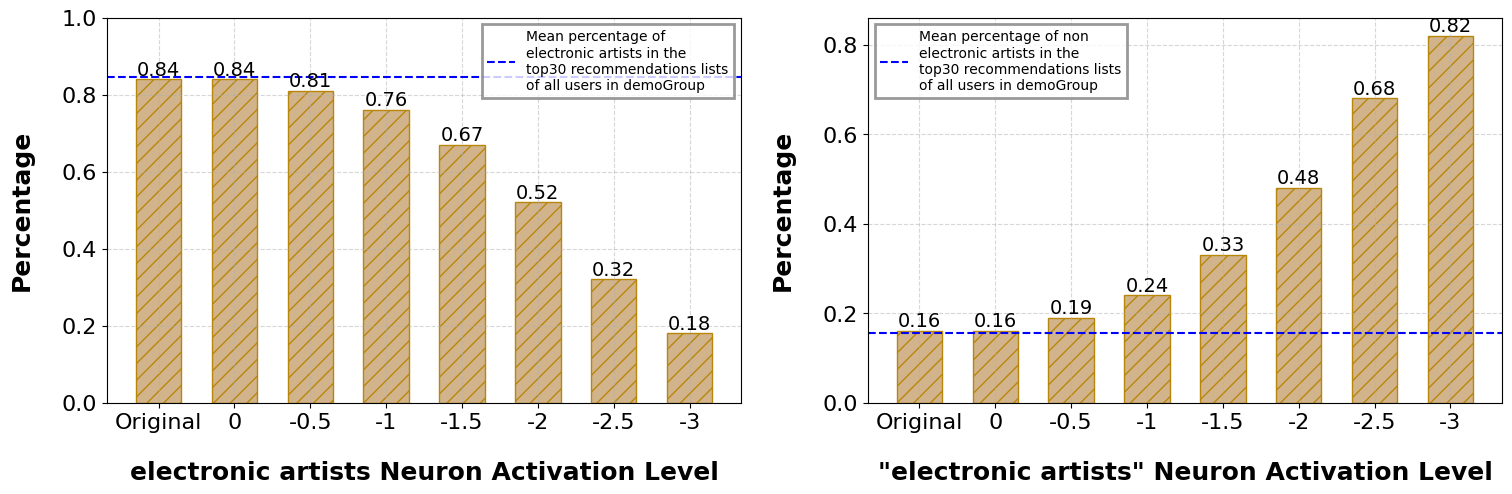

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0
genre_expose = 'electronic'


'''dealing here with orig/new results and old/new genres'''

neuron_levels = [-0.5,0,0.5,1,1.5,2,2.5,3]


'''what place 'test_movie' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(usersGroup.index)), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:
 no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in usersGroup.index:


    top_rec_user_orig = get_top_k_recommendations_new_all(model, user2,dataset_users, dataset_items, range(2277), movie_num2)[1]
    top_rec_user_id_orig = top_rec_user_orig.tolist()

    a_orig = df_artists_tags.iloc[top_rec_user_id_orig,:].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[genre_expose])/movie_num2

    orig_genres_percentage_newGenre = a_orig.loc[genre_expose]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)



    # new/ current results: for old and new/test/curr genres:

    # modified users:
    x2 = dataset_users[user2].view(1, 100)
    latent_pre_act = sae_model.encoder_linear(x2)
    curr_latents2 = sae_model.topk_activation(latent_pre_act)
    curr_latents2 = latents_all_usr[user2].clone()

    min_val2 = curr_latents2.min()
    max_val2 = curr_latents2.max()
    curr_latents2 = (curr_latents2 - min_val2) / (max_val2 - min_val2 + 1e-8)  # Normalize to [0,1]

    # print(curr_latents2)
    if level != -0.5:
      curr_latents2[33]=level*(-1)

    curr_latents2= curr_latents2 * (max_val2 - min_val2) + min_val2
    recons_user2 = sae_model.decoder(curr_latents2)

    df_user_emb_copy2= dataset_users.clone()
    df_user_emb_copy2[user2,:] = recons_user2.detach()

    top_rec_user2 = get_top_k_recommendations_new_all(model, user2,df_user_emb_copy2, dataset_items, range(2277), movie_num2)[1]
    top_rec_user_id_new2 = top_rec_user2.tolist()

    a2 = df_artists_tags.iloc[top_rec_user_id_new2,:].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[genre_expose])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[genre_expose]/movie_num2


    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)

  # each item in the list represents the averaged percentage of movies of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))
#  meanTestGenreMoviesInTopK4DemoGroup_orig.append(genresNew_percentage_all_orig.mean())

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))
  # meanTestGenreMoviesInTopK4DemoGroup.append(genresNew_percentage_all.mean())


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


# IF WE'RE TALKING ABOUT BLOCKIING- ADD THIS REPLACE WITH neuron_levels_names
neuron_levels_block = neuron_levels.copy()
neuron_levels_block = [item* (-1) for item in neuron_levels_block]
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.3, hatch='//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
ax1.set_xlabel(f'{genre_expose} artists Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)
ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=16)
leg = ax1.legend([f'Mean percentage of\n{genre_expose} artists in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax2.bar(neuron_levels, b, color='tan', width= 0.3, hatch='//', edgecolor = 'darkgoldenrod')
ax2.bar_label(r2,fontsize=14)
# ax2.bar(neuron_levels, meanOldGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax2.set_title(f'Mean percentage of non Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax2.set_xlabel(f'"{genre_expose} artists" Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non\n{genre_expose} artists in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)
# Access the legend frame and set its edge color and
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)




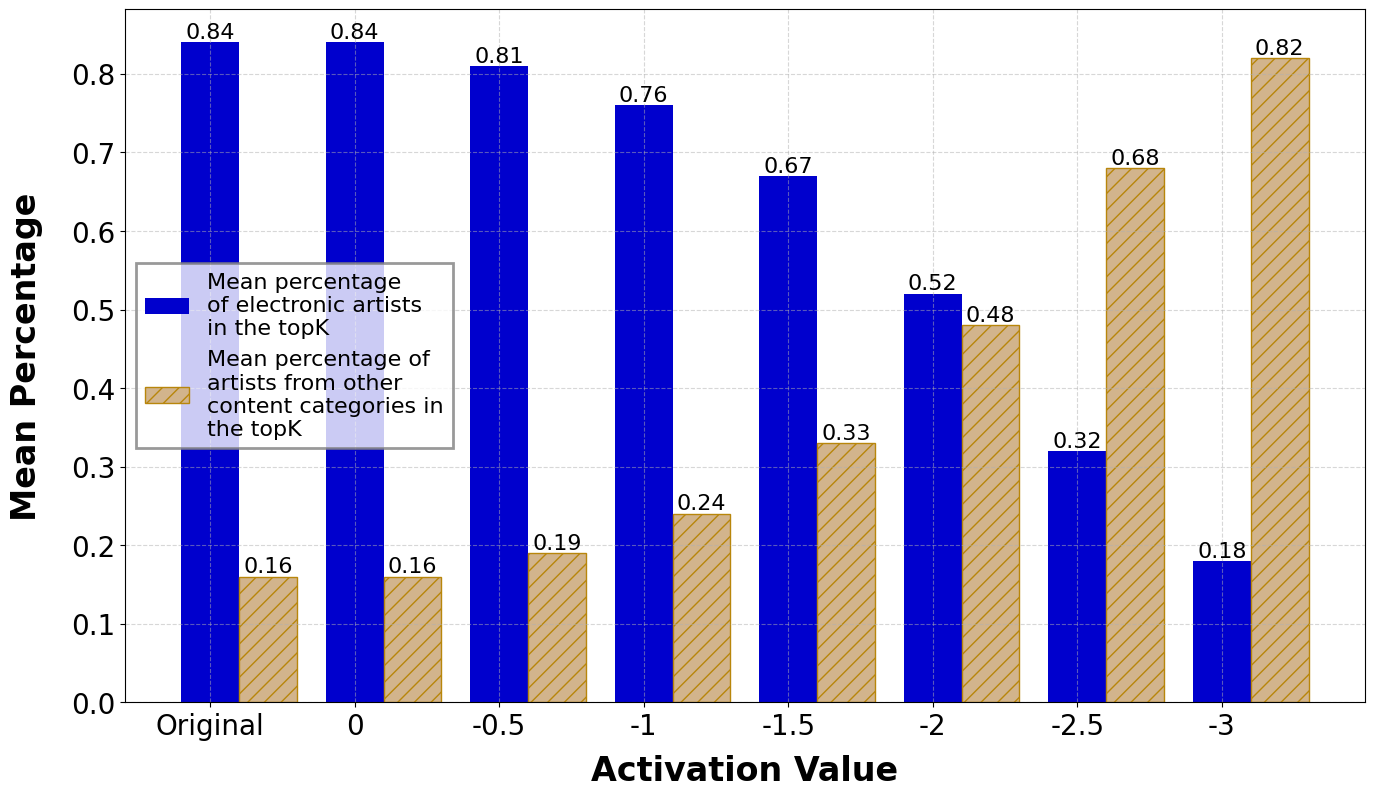

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16, 9))


# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='mediumblue', width= 0.2)
ax1.bar_label(r1,fontsize=16)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([-0.3,0.2,0.70, 1.2, 1.70,2.2,2.7,3.2], b,color = 'tan', width= 0.2,hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r2,fontsize=16)


ax1.set_xlabel('Activation Value', labelpad=10,weight='bold',fontsize=24)
ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=24)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.tick_params(axis='both', labelsize=20)
ax1.set_xticks(neuron_levels)
ax1.set_xticklabels(neuron_levels_block,fontsize=20)

leg = plt.legend([f'Mean percentage\nof {genre_expose} artists\nin the topK', f'Mean percentage of\nartists from other\ncontent categories in\nthe topK'],frameon=True, loc='best', fontsize=16, fancybox=False)

frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






-

# NCF SAE loss term

test the rank correlation scores using RBO & Kentall Tau wrt prediction level loss term

In [ ]:
test_flag=1
val_output_loss_weight = 0


model_name_SAE_NCF = 'SAE_NCF_loss_weight2'

sae_model = SparseAutoencoderNCF(input_dim=20, hidden_dim=22, topk=7, tie_weights=True)
sae_model = torch.load(Path(export_dir,f'models/lastFM/others/NCF/{model_name_SAE_NCF}.pth'), weights_only = False)
sae_model.eval()
test_subset_users = sae_model.test_subset_users_ind
test_subset_items = sae_model.test_subset_items_ind
train_subset_users = [i for i in user_artist_matrix.index if i not in test_subset_users]


# extract latents:
reconstructions_users, latents_users=sae_model(user_embeddings)
reconstructions_items, latents_items=sae_model(item_embeddings)

latents_users=latents_users.detach().clone()
latents_items=latents_items.detach().clone()

reconstructions_users=reconstructions_users.detach().clone()
reconstructions_items=reconstructions_items.detach().clone()

avg_ms_score= ms_score_new(df_cosine_sim_matrix, latents_items)

users_ind= sae_model.test_subset_users_ind

lists_compare_table = pd.DataFrame(0, index=users_ind, columns=['RBO Score', 'Kendall Tau Score'])


for user in lists_compare_table.index:

    top_rec_user_id_orig  = get_top_k_recommendations(model,user_id,range(2277), 30)[0]
    top_rec_user_id_rec  = get_top_k_recommendations_new(model, user,reconstructions_users, reconstructions_items, range(2277), 30)[0]

    lists_compare_table.loc[user,'RBO Score'] = rbo(top_rec_user_id_orig, top_rec_user_id_rec)

    lists_compare_table.loc[user,'Kendall Tau Score'] = kendall_tau(top_rec_user_id_orig], top_rec_user_id_rec)

print(f'{round(float(lists_compare_table.mean().iloc[0]),6)} | {round(float(lists_compare_table.mean().iloc[1]),6)}')
print(f'averaged MS score: {avg_ms_score}')



# MF & NCF SAE loss term

insert results into graph:

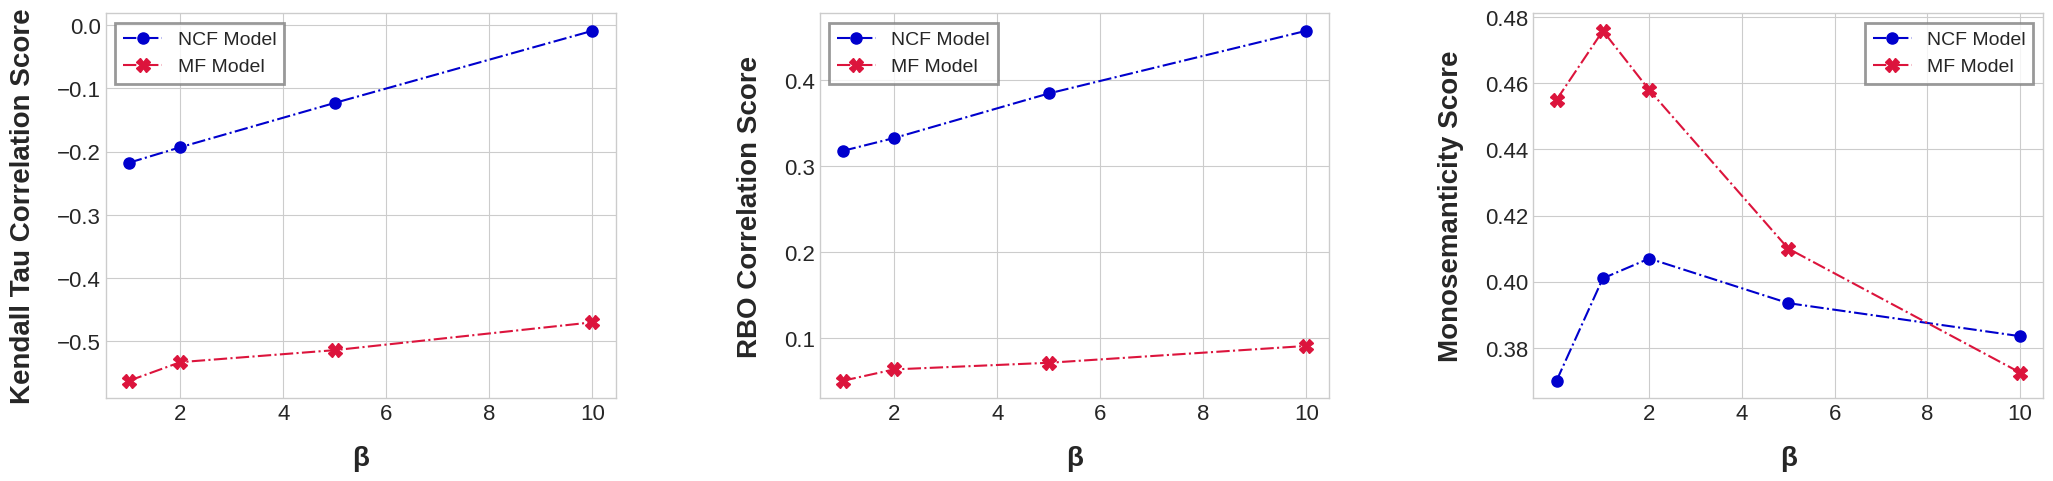

In [ ]:
# Use a Seaborn style (or any style you prefer)
plt.style.use('seaborn-v0_8-whitegrid')

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Graph 1 ---
# ax1.plot([1, 2, 5, 10], [0.24, 0.3, 0.448, 0.6], color='mediumblue', ls='-.', marker='o',markersize = 8)
# ax1.plot([1, 2,5, 10],[0.092,0.141, 0.226, 0.315], color='crimson', ls='-.', marker='X', markersize = 10)
ax1.set_xlabel('Loss Weight Value', labelpad=15, weight='bold', fontsize=20)
ax1.set_ylabel('Kendall Tau Correlation Score', labelpad=15, weight='bold', fontsize=20)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
leg1 = ax1.legend(['NCF Model', 'MF Model'], frameon=True, loc='best', fontsize=14, fancybox=False)
leg1.get_frame().set_edgecolor('grey')
leg1.get_frame().set_linewidth(2)

# --- Graph 2 ---
# (Replace the data below with your desired plot data for the second graph.)
# ax2.plot([1, 2, 5, 10], [0.54, 0.579,0.668, 0.759], color='mediumblue', ls='-.', marker='o',markersize = 8)
# ax2.plot([1,2, 5, 10], [0.403, 0.436, 0.4859, 0.543], color='crimson', ls='-.', marker='X', markersize = 10)
ax2.set_xlabel('Loss Weight Value', labelpad=15, weight='bold', fontsize=20)
ax2.set_ylabel('RBO Correlation Score', labelpad=15, weight='bold', fontsize=20)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
leg2 = ax2.legend(['NCF Model', 'MF Model'], frameon=True, loc='best', fontsize=14, fancybox=False)
leg2.get_frame().set_edgecolor('grey')
leg2.get_frame().set_linewidth(2)

fig.subplots_adjust(wspace=0.4)

# plt.tight_layout()
plt.show()

